In [1]:
import IdentifyNeurons
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import os
import sys
#make sure that the algorithm detects the first frame's neuron

img_dirs = "/datahub/iGEM2017/RawData/20190418_R-GECO/WL0810-1-BlueLight/Pos0/"
out_dirs = "/datahub/iGEM2017/Results/20190418_R-GECO/"
files = os.listdir(img_dirs)
files.sort()

NeuronsInFrames = []
for imgname in files:
    path = img_dirs+imgname
    #print(path)
    try:
        #print('yes')
        Neurons = IdentifyNeurons.IdentifyNeurons(path, threshold = 150, areamin = 110, areamax = 400)
        NeuronsInFrames.append(Neurons)
    except:
        pass
print(len(NeuronsInFrames))

300


In [ ]:
from imp import reload
reload(IdentifyNeurons)

In [2]:
NeuronsPos = np.array(NeuronsInFrames)

In [ ]:
NeuronsPos[0] = NeuronsPos[0][0]

In [6]:
for i  in range(len(NeuronsPos)):
    print(i)
    print(NeuronsPos[i])

0
[array([1123,  803,   16,   17,  195], dtype=int32)]
1
[array([1123,  803,   14,   15,  147], dtype=int32)]
2
[array([1124,  804,   13,   14,  135], dtype=int32)]
3
[array([1124,  803,   13,   14,  136], dtype=int32)]
4
[array([1124,  803,   13,   15,  141], dtype=int32)]
5
[array([1124,  803,   12,   14,  135], dtype=int32)]
6
[array([1123,  803,   14,   14,  140], dtype=int32)]
7
[array([1124,  803,   13,   13,  128], dtype=int32)]
8
[array([1124,  803,   13,   14,  128], dtype=int32)]
9
[array([1124,  803,   13,   14,  135], dtype=int32)]
10
[array([1124,  803,   12,   13,  124], dtype=int32)]
11
[array([1124,  802,   12,   14,  128], dtype=int32)]
12
[array([1124,  802,   12,   14,  126], dtype=int32)]
13
[array([1124,  803,   13,   13,  129], dtype=int32)]
14
[array([1124,  802,   13,   14,  127], dtype=int32)]
15
[array([1123,  802,   14,   14,  146], dtype=int32)]
16
[array([1124,  802,   13,   14,  128], dtype=int32)]
17
[array([1124,  802,   13,   14,  134], dtype=int32)]
18

In [3]:
def NeuronLikelyhood(Neurons):
    for index in range(len(Neurons)):
        neu = Neurons[index]
        if len(neu)>1:
            preneu = Neurons[index-1]
            dis = 99999999
            for indi in neu:
                newdis = (indi[0]-preneu[0][0])**2+(indi[1]-preneu[0][1])**2
                if newdis<dis:
                    newneu = indi
            Neurons[index] = [newneu]
    return Neurons

#make sure that the algorithm detects the first frame's neuron
def NeuPositionMakeup(Positions):
    PreTag = 0
    PostTag = -1
    Jump = False
    Gaps = 0
    for pos in range(len(Positions)):
        if not np.any(Positions[pos]):
            Jump = True
            Gaps +=1
        elif not Jump:
            PreTag = pos
            Jump = False
        else:
            PostTag = pos
            Jump = False
            for j in range(1,Gaps+1):
                Positions[PreTag+j] = np.array([(pre+post)/2 for pre in NeuronsPos[PreTag] for post in NeuronsPos[PostTag]])
                Positions[PreTag+j].astype(int)
            PreTag = pos
            Gaps = 0
    return Positions

In [ ]:
NeuronsPos = NeuronLikelyhood(NeuronsPos)

In [4]:
for i  in range(len(NeuronsPos)):
    if len(NeuronsPos[i])>1:
        NeuronsPos[i] = []

In [5]:
NeuronsPos = NeuPositionMakeup(NeuronsPos)

In [ ]:
for i  in range(len(NeuronsPos)):
    print(i)
    print(NeuronsPos[i])

In [ ]:
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [54]:
fps = 0.5
sti_begin = 25
window_size = 1 


# Local the neurons
# [x0, y0, width, height, area] in each NeuronPos[i] with
#type int32 and flooat
pos = NeuronsPos
neuronnum = len(pos[0])

#bg = (1297, 924, 1354, 1007)
bg = (1112,961,1142,991)

fluo_0 = np.zeros([len(pos), neuronnum]) # raw fluorescnece
fluo_a = np.zeros([len(pos), neuronnum]) # autofluorescence

# extra fluorescence
frame = 0
fluo_t = np.zeros(neuronnum)
fluo_a_t = np.zeros(neuronnum)
#that is a reduntant step if memory is  enough
imgpath = []
for imgname in files:
    path = img_dirs+imgname
    #print(path)
    img = cv.imread(path,-1)
    #print(img)
    if np.all(img):
        imgpath.append(path)
imgpath.sort()


In [60]:
frame = 0
neuronwidth = 10# neuronwifth is radius
for path in imgpath:
    img = cv.imread(path, -1)
    #img = cv.GaussianBlur(img,(5,5), 4)
    img_bg = img[bg[0]:bg[2], bg[1]:bg[3]]
    thispos = pos[frame]
    for neuron in range(neuronnum):
        x_0 = int(thispos[neuron][0])
        y_0 = int(thispos[neuron][1])
        #fluo_t[neuron] = np.mean(img[v_0:v_1, h_0:h_1])
        imgneuron = img[y_0-neuronwidth:y_0+neuronwidth,x_0-neuronwidth:x_0+neuronwidth]
        print(path)
        imgneuron_flatten = imgneuron.flatten()
        imgneuron_flatten.sort()
        #fluo_t[neuron] = np.mean(imgneuron)
        fluo_t[neuron] = np.mean(imgneuron_flatten[-100:-1])
        print(fluo_t[neuron])
        fluo_a_t = np.mean(img_bg)
    fluo_0[frame] = fluo_t
    fluo_a[frame] = fluo_a_t
    frame = frame + 1





/datahub/iGEM2017/RawData/20190418_R-GECO/WL0810-1-BlueLight/Pos0/img_channel000_position000_time000000000_z000.tif
554.8282828282828
/datahub/iGEM2017/RawData/20190418_R-GECO/WL0810-1-BlueLight/Pos0/img_channel000_position000_time000000001_z000.tif
580.4040404040404
/datahub/iGEM2017/RawData/20190418_R-GECO/WL0810-1-BlueLight/Pos0/img_channel000_position000_time000000002_z000.tif
600.0
/datahub/iGEM2017/RawData/20190418_R-GECO/WL0810-1-BlueLight/Pos0/img_channel000_position000_time000000003_z000.tif
595.2323232323232
/datahub/iGEM2017/RawData/20190418_R-GECO/WL0810-1-BlueLight/Pos0/img_channel000_position000_time000000004_z000.tif
593.5858585858585
/datahub/iGEM2017/RawData/20190418_R-GECO/WL0810-1-BlueLight/Pos0/img_channel000_position000_time000000005_z000.tif
604.4444444444445
/datahub/iGEM2017/RawData/20190418_R-GECO/WL0810-1-BlueLight/Pos0/img_channel000_position000_time000000006_z000.tif
596.4848484848485
/datahub/iGEM2017/RawData/20190418_R-GECO/WL0810-1-BlueLight/Pos0/img_chan

/datahub/iGEM2017/RawData/20190418_R-GECO/WL0810-1-BlueLight/Pos0/img_channel000_position000_time000000093_z000.tif
570.2727272727273
/datahub/iGEM2017/RawData/20190418_R-GECO/WL0810-1-BlueLight/Pos0/img_channel000_position000_time000000094_z000.tif
566.6060606060606
/datahub/iGEM2017/RawData/20190418_R-GECO/WL0810-1-BlueLight/Pos0/img_channel000_position000_time000000095_z000.tif
574.7676767676768
/datahub/iGEM2017/RawData/20190418_R-GECO/WL0810-1-BlueLight/Pos0/img_channel000_position000_time000000096_z000.tif
574.4848484848485
/datahub/iGEM2017/RawData/20190418_R-GECO/WL0810-1-BlueLight/Pos0/img_channel000_position000_time000000097_z000.tif
574.6464646464647
/datahub/iGEM2017/RawData/20190418_R-GECO/WL0810-1-BlueLight/Pos0/img_channel000_position000_time000000098_z000.tif
570.3232323232323
/datahub/iGEM2017/RawData/20190418_R-GECO/WL0810-1-BlueLight/Pos0/img_channel000_position000_time000000099_z000.tif
570.3434343434343
/datahub/iGEM2017/RawData/20190418_R-GECO/WL0810-1-BlueLight/P

/datahub/iGEM2017/RawData/20190418_R-GECO/WL0810-1-BlueLight/Pos0/img_channel000_position000_time000000156_z000.tif
564.6060606060606
/datahub/iGEM2017/RawData/20190418_R-GECO/WL0810-1-BlueLight/Pos0/img_channel000_position000_time000000157_z000.tif
557.4343434343434
/datahub/iGEM2017/RawData/20190418_R-GECO/WL0810-1-BlueLight/Pos0/img_channel000_position000_time000000158_z000.tif
554.040404040404
/datahub/iGEM2017/RawData/20190418_R-GECO/WL0810-1-BlueLight/Pos0/img_channel000_position000_time000000159_z000.tif
555.8585858585859
/datahub/iGEM2017/RawData/20190418_R-GECO/WL0810-1-BlueLight/Pos0/img_channel000_position000_time000000160_z000.tif
561.8787878787879
/datahub/iGEM2017/RawData/20190418_R-GECO/WL0810-1-BlueLight/Pos0/img_channel000_position000_time000000161_z000.tif
558.1414141414141
/datahub/iGEM2017/RawData/20190418_R-GECO/WL0810-1-BlueLight/Pos0/img_channel000_position000_time000000162_z000.tif
556.8181818181819
/datahub/iGEM2017/RawData/20190418_R-GECO/WL0810-1-BlueLight/Po

/datahub/iGEM2017/RawData/20190418_R-GECO/WL0810-1-BlueLight/Pos0/img_channel000_position000_time000000220_z000.tif
549.6868686868687
/datahub/iGEM2017/RawData/20190418_R-GECO/WL0810-1-BlueLight/Pos0/img_channel000_position000_time000000221_z000.tif
546.6262626262626
/datahub/iGEM2017/RawData/20190418_R-GECO/WL0810-1-BlueLight/Pos0/img_channel000_position000_time000000222_z000.tif
541.2020202020202
/datahub/iGEM2017/RawData/20190418_R-GECO/WL0810-1-BlueLight/Pos0/img_channel000_position000_time000000223_z000.tif
545.2727272727273
/datahub/iGEM2017/RawData/20190418_R-GECO/WL0810-1-BlueLight/Pos0/img_channel000_position000_time000000224_z000.tif
541.7676767676768
/datahub/iGEM2017/RawData/20190418_R-GECO/WL0810-1-BlueLight/Pos0/img_channel000_position000_time000000225_z000.tif
546.030303030303
/datahub/iGEM2017/RawData/20190418_R-GECO/WL0810-1-BlueLight/Pos0/img_channel000_position000_time000000226_z000.tif
540.1414141414141
/datahub/iGEM2017/RawData/20190418_R-GECO/WL0810-1-BlueLight/Po

532.4848484848485
/datahub/iGEM2017/RawData/20190418_R-GECO/WL0810-1-BlueLight/Pos0/img_channel000_position000_time000000285_z000.tif
533.3232323232323
/datahub/iGEM2017/RawData/20190418_R-GECO/WL0810-1-BlueLight/Pos0/img_channel000_position000_time000000286_z000.tif
525.060606060606
/datahub/iGEM2017/RawData/20190418_R-GECO/WL0810-1-BlueLight/Pos0/img_channel000_position000_time000000287_z000.tif
529.3232323232323
/datahub/iGEM2017/RawData/20190418_R-GECO/WL0810-1-BlueLight/Pos0/img_channel000_position000_time000000288_z000.tif
537.2424242424242
/datahub/iGEM2017/RawData/20190418_R-GECO/WL0810-1-BlueLight/Pos0/img_channel000_position000_time000000289_z000.tif
523.9090909090909
/datahub/iGEM2017/RawData/20190418_R-GECO/WL0810-1-BlueLight/Pos0/img_channel000_position000_time000000290_z000.tif
528.4949494949495
/datahub/iGEM2017/RawData/20190418_R-GECO/WL0810-1-BlueLight/Pos0/img_channel000_position000_time000000291_z000.tif
533.3939393939394
/datahub/iGEM2017/RawData/20190418_R-GECO/WL0

IndexError: list index out of range

In [ ]:
print(fluo_0)

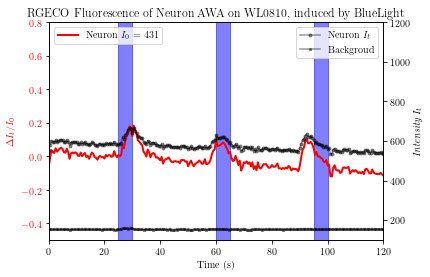

In [61]:
## remove auto fluorescence
fluo_ex = fluo_0 - fluo_a
t = np.linspace(0, len(fluo_0)-1, len(fluo_0)) * fps
fluo_t0 = []

for neuron in range(neuronnum):
    fluo_t0.append(np.mean(fluo_ex[0:5, neuron]))
fluo_normal = fluo_ex/fluo_t0 - 1

fig, axl = plt.subplots()
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.title("RGECO Fluorescence of Neuron AWA on WL0810, induced by BlueLight")

for stimuate in range(3):
    sti0 = stimuate*35 + sti_begin
    plt.fill_between(np.linspace(sti0, sti0+5), 3,-1.5, color='b', alpha=0.5)

axr = axl.twinx()
axr.set_ylabel(r'\textit{Intensity $I_t$}')
axr.plot(t, fluo_0, color='k', alpha=0.4, marker = 'o', markersize = 3, label=r'Neuron $I_t$')#marker = 'o', markersize = 3,
axr.plot(t, fluo_a, color='k', alpha=0.4,  marker = '*', markersize = 3,label='Backgroud')#marker = '*', markersize = 3,
axr.set_ylim(100, 1200)
axr.legend(loc = 'upper right')

axl.set_xlabel('Time (s)')
axl.set_ylabel(r'$\Delta I_t/I_0$', color='r')
axl.plot(t, fluo_normal, color='r', linewidth=2,label='Neuron'+r' $I_0=$' + ' %d'%fluo_t0[0])
axl.tick_params(axis='y', labelcolor='r')
axl.set_xlim(0,120)
axl.set_ylim(-0.5, 0.8)
axl.legend(loc = 'upper left')

#fig.tight_layout()
#plt.savefig(out_dirs + '/'+ os.path.basename(img_dirs) +'.png', dpi=300)
img_name = "WL0810-1-blue_light"
plt.savefig(out_dirs + '/'+ img_name +'.png', dpi=300)
np.save(out_dirs + '/' + img_name + '_fluo_normal.npy', fluo_normal)
#plt.savefig(out_dirs + '/'+ name +'.png', dpi=300)